In [1]:
#!pip install --upgrade pip
#!pip install -r requirements.txt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from src.preprocess import get_average_vector


# Load the training data
training_data = pd.read_excel('data/training_set_rel3.xls')

# Load the validation data
validation_data = pd.read_excel('data/valid_set.xls')

training_data.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,NaN,10.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below we check the correlation between domain1_score and domain2_score of the group 2

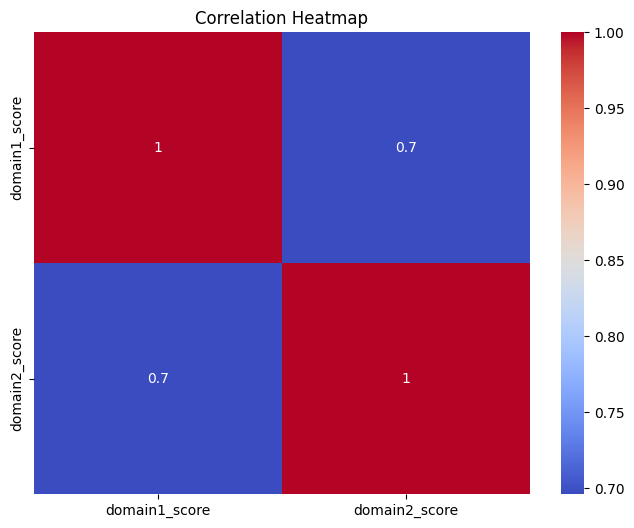

In [2]:
group2_data = training_data[training_data['essay_set'] == 2]
   
correlation_1 = group2_data[['domain1_score','domain2_score']].corr()
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_1, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

 There is a positive correlation between the scores of domain1 and domain2, with a correlation coefficient of approximately 0.696186.

# Splitting the dataset

In [3]:
# Get unique groups in the essay_set column
groups = training_data['essay_set'].unique()

for group in groups:
    # Filter the data for the current group
    group_data = training_data[training_data['essay_set'] == group]
    print(f"The shape of group {group} is ", group_data.shape)

The shape of group 1 is  (1783, 28)
The shape of group 2 is  (1800, 28)
The shape of group 3 is  (1726, 28)
The shape of group 4 is  (1772, 28)
The shape of group 5 is  (1805, 28)
The shape of group 6 is  (1800, 28)
The shape of group 7 is  (1569, 28)
The shape of group 8 is  (723, 28)


#### Why the need of stratified Sampling?

From the above result, the number of samples (rows) per group varies significantly across different groups. When splitting the dataset into training and validation sets, we want to ensure that both sets are representative of the overall distribution of classes/groups. If we were to use a simple random split without considering the class distribution, we might end up with training and validation sets that do not adequately represent certain groups, especially the smaller ones. Stratified sampling helps address this issue by ensuring that each group is proportionally represented in both the training and validation sets. This is important for training a model that generalizes well to all groups, not just those that are more numerous in the dataset.

In [4]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import numpy as np
from src.preprocess import get_average_vector


# Function to drop rater traits
def drop_rater_traits(df):
    columns_to_drop = [col for col in df.columns if 'trait' in col]
    return df.drop(columns=columns_to_drop)

# Function to drop rater traits
def drop_raters_score(df):
    columns_to_drop = [col for col in df.columns if 'rater' in col]
    return df.drop(columns=columns_to_drop)

# Main training pipeline
def training_pipeline(df):
    # Drop rater trait columns
    df = drop_rater_traits(df)
    df = drop_raters_score(df)
    return df

In [5]:
preprocessed = training_pipeline(training_data)

In [6]:
preprocessed

,essay_id,essay_set,essay,domain1_score,domain2_score
0,1,1,"Dear local newspaper, I think effects computer...",8.0,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",8.0,NaN
...,...,...,...,...,...
12973,21626,8,In most stories mothers and daughters are eit...,35.0,NaN
12974,21628,8,I never understood the meaning laughter is th...,32.0,NaN
12975,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",40.0,NaN
12976,21630,8,Trippin' on fen...,40.0,NaN


In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
# Define the number of splits and the test size for the validation set
n_splits = 1
test_size = 0.2  # You can adjust the test_size based on your requirements

# Initialize StratifiedShuffleSplit
stratified_splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

# Split the data
for train_index, val_index in stratified_splitter.split(preprocessed, preprocessed['essay_set']):
    X_train, X_val = preprocessed.iloc[train_index], preprocessed.iloc[val_index]
    y_train, y_val = preprocessed['essay_set'][train_index], preprocessed['essay_set'][val_index]

In [26]:
X_train

,essay_id,essay_set,essay,domain1_score,domain2_score
6578,10135,4,The reason why the author concludes the story ...,2.0,NaN
2936,4131,2,Would you censor the @CAPS1? i @CAPS2 i sure w...,3.0,2.0
4209,6606,3,The cyclist has to over come a lot of obstacle...,2.0,NaN
10059,16007,6,Due to the architects being blind to the poten...,4.0,NaN
7855,12601,5,"In the article ""Narciso Rodriguez"" from Home: ...",1.0,NaN
...,...,...,...,...,...
7307,12053,5,"He/she makes you try to be sad, I dont even kn...",0.0,NaN
11238,18459,7,My mom woke me up early in the morning and sai...,18.0,NaN
8405,13151,5,The mood created by the author in this memoir ...,2.0,NaN
1866,3061,2,"Dear Katherine Paterson, Do you believ...",3.0,3.0


In [27]:
y_train.shape, y_val.shape

((10382,), (2596,))

In [28]:
from src.preprocess import analyze_essay_text

# Analyze the training data
train_feature = X_train['essay'].apply(analyze_essay_text)
val_feature = X_val['essay'].apply(analyze_essay_text)

train_df = pd.DataFrame(train_feature.tolist())
val_df = pd.DataFrame(val_feature.tolist())
train_df.head()

,Number of characters,Number of words,Number of capital characters,Number of capital words,Number of sentences,Number of unique words,Number of stopwords,Number of punctuation,Average word length,Average sentence length,Unique words vs word count feature,Stopwords count vs words count feature
0,1000,208,8,2,3,106,117,5,3.831731,332.666667,0.509615,0.562500
1,2358,505,117,23,30,231,212,72,3.770297,77.033333,0.457426,0.419802
2,361,80,5,0,5,55,41,9,3.650000,71.200000,0.687500,0.512500
3,1535,284,20,0,12,157,123,15,4.461268,127.000000,0.552817,0.433099
4,409,89,11,0,5,46,41,11,3.752809,81.000000,0.516854,0.460674


In [29]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Create XGBoost classifier for multiclass classification with increased complexity
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=8,  # Adjust for the number of classes in your dataset
    n_estimators=600,  # Increase the number of trees (boosting rounds)
    max_depth=10,  # Increase the maximum depth of each tree
    learning_rate=0.01,  # Adjust the learning rate
    subsample=0.9,  # Adjust the subsample ratio
    colsample_bytree=0.8,  # Adjust the fraction of features for each tree
    gamma=0,  # Adjust the minimum loss reduction to make a further partition on a leaf node
    random_state=42
)
y_train_ = y_train - 1
y_val_= y_val - 1

# Train the classifier
xgb_classifier.fit(train_df, y_train_)

# Predict on the validation set
y_pred_classify = xgb_classifier.predict(val_df)

# Evaluate the classification accuracy
accuracy = accuracy_score(y_val_, y_pred_classify)
print(f"Classification Accuracy: {accuracy}")

# Cross-validation
cv_scores = cross_val_score(xgb_classifier, train_df, y_train_, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean()}")

# You can also print the individual cross-validation scores
print("Individual Cross-Validation Scores:", cv_scores)


Classification Accuracy: 0.6629429892141756
Cross-Validation Accuracy: 0.6526683197846309
Individual Cross-Validation Scores: [0.65623495 0.64660568 0.65414258 0.6522158  0.65414258]


In [31]:
y_pred_classify

array([1, 2, 3, ..., 6, 2, 1], dtype=int32)

In [91]:
# Regression
y_reg1 = X_train['domain1_score']
y_reg2 = X_train['domain2_score'].fillna(0)  # Handle NaN in 'domain2_score'


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Create a more complex RandomForestRegressor
rf_regressor1 = RandomForestRegressor(
    n_estimators=300,  # Increase the number of trees
    max_depth=10,  # Increase the maximum depth of each tree
    min_samples_split=2,  # Adjust the minimum samples required to split an internal node
    min_samples_leaf=1,  # Adjust the minimum number of samples required to be at a leaf node
    max_features='sqrt',  # Adjust the number of features to consider for the best split
    random_state=42
)

rf_regressor2 = RandomForestRegressor(
    n_estimators=300,  # Increase the number of trees
    max_depth=10,  # Increase the maximum depth of each tree
    min_samples_split=2,  # Adjust the minimum samples required to split an internal node
    min_samples_leaf=1,  # Adjust the minimum number of samples required to be at a leaf node
    max_features='sqrt',  # Adjust the number of features to consider for the best split
    random_state=42
)
y_val_reg1 = X_val['domain1_score'].fillna(0)
y_val_reg2 = X_val['domain2_score'].fillna(0)  # Handle NaN in 'domain2_score'


# Train the regressors
rf_regressor1.fit(train_df, y_reg1)
rf_regressor2.fit(train_df, y_reg2)

# Predict on the validation set
y_pred_reg1 = rf_regressor1.predict(val_df)
y_pred_reg2 = rf_regressor2.predict(val_df)

# Evaluate the regression performance using Mean Squared Error
mse_reg1 = mean_squared_error(y_pred_reg1 , y_pred_reg1)
mse_reg2 = mean_squared_error(y_pred_reg2, y_pred_reg2)

print(f"Mean Squared Error (Regressor 1): {mse_reg1}")
print(f"Mean Squared Error (Regressor 2): {mse_reg2}")

# Cross-validation
#cv_scores_reg1 = cross_val_score(rf_regressor1, X_train, y_train_reg1, cv=5, scoring='neg_mean_squared_error')
#cv_scores_reg2 = cross_val_score(rf_regressor2, X_train, y_train_reg2, cv=5, scoring='neg_mean_squared_error')

#print(f"Cross-Validation Mean Squared Error (Regressor 1): {cv_scores_reg1.mean()}")
#print(f"Cross-Validation Mean Squared Error (Regressor 2): {cv_scores_reg2.mean()}")

NameError: name 'y_reg1' is not defined

In [94]:
# Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

regressor1 = RandomForestRegressor(n_estimators=100, random_state=42)
regressor2 = RandomForestRegressor(n_estimators=100, random_state=42)

regressor1.fit(train_df, y_reg1)
regressor2.fit(train_df, y_reg2)

y_pred_reg1 = regressor1.predict(val_df)
y_pred_reg2 = regressor2.predict(val_df)


In [95]:
y_val_reg1 = X_val['domain1_score'].fillna(0)
y_val_reg2 = X_val['domain2_score'].fillna(0)  # Handle NaN in 'domain2_score'


mse1 = mean_squared_error(y_val_reg1 , y_pred_reg1)
mse2 = mean_squared_error(y_val_reg2, y_pred_reg2)

print(f"Regression MSE (domain1_score): {mse1}")
print(f"Regression MSE (domain2_score): {mse2}")

Regression MSE (domain1_score): 27.175282973805857
Regression MSE (domain2_score): 0.7242654853620955


In [96]:
y_pred_reg1

array([ 4.91,  2.95,  1.99, ..., 18.05,  2.97,  5.27])